<img src="../../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Brain Observatory - Visual Behavior </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">Tuesday, August 24, 2021</h3> 


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Visual Behavior Exercises Overview </h2>
    
<p> This notebook contains exercises covering several topics including behavior performance, single cell physiology and across session analysis.
  
<p> The exercises can be done in sequential order, or you can skip around to the exercises that interest you most. 
    
<p> If you get stuck, please ask a TA for help, look it up on stackoverflow, or check the solutions notebook. 
    We dont expect you to know everything already - the goal is to learn, and learning requires making mistakes and asking questions. 

<h3>Outline </h3>

<p><b>Behavior Exercises</b>
<ul><li>Exercise 1.1: Plot the distribution of reaction times for go trials from one session
    <li>Exercise 1.2: Plot reward rate over time during a session
<li>Exercise 1.3: Compute and plot hit rate over time during a session
<li>Exercise 1.4: Plot the average hit rate for each image. Dislay presented stimuli
<li>Exercise 1.5: Plot the correct response probability for all image transitions
</ul>
<p><b>Single Cell Physiology Exercises</b> - this section requires stimulus_response_df as well as other mindscope_utilities functions
<ul><li>Exercise 2.1: Plot neural activity during image changes using the stimulus response dataframe and stimulus_presentations
<li>Exercise 2.2: Correlate neural activity with running speed on a trial by trial basis. Binarize trials into running and stationary
<li>Exercise 2.3: Plot the trial averaged response across changes for one or all cells using the trial response dataframe. Examine pupil size effect on change responses
<li>Exercise 2.4: Create a heatmap of all cells' averaged responses following an image change. 


</ul>
<p><b>Across Session Physiology Exercises</b>
<ul><li>Exercise 3.1: Get stimulus aligned responses for all experiments in a container from a Vip mouse
<li>Exercise 3.2: Plot population average omission response across all experiments in a container
<li>Exercise 3.3: Plot population average change response across all experiments in a container
<li>Exercise 3.4: Plot the average omission response for a single cell across all experiments in a container
<li>Exercise 3.5: Plot the average response across all imaging planes in a single Multiscope session
</ul>
</div>

In [1]:
# you will need these libraries for computation & data manipulation
import os
import numpy as np
import pandas as pd

# matplotlib is a standard python visualization package
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn is another library for statistical data visualization
# seaborn style & context settings make plots pretty & legible automatically
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white');
sns.set_palette('deep');

In [2]:
# Import allensdk modules for loading and interacting with the data
from allensdk.brain_observatory.behavior.behavior_project_cache \
import VisualBehaviorOphysProjectCache

In [3]:
# This cell will find the appropriate path to the data based on your platform.
# You may need to edit the strings in this cell based on your configuration.

import platform
platstring = platform.platform()

if 'Darwin' in platstring:
    # macOS
    data_root = "/Volumes/Brain2019/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of the hard drive)
    data_root = "E:/"
elif ('amzn1' in platstring):
    # then on AWS
    data_root = "/data/"
else:
    # then linux (default here is for Ubuntu - insert your username; your distribution may differ)
    data_root = "/media/$USERNAME/Brain2019"
    
cache_path = os.path.join(data_root, 'dynamic-brain-workshop/visual_behavior/2021')

In [8]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Pick an ophys experiment based on its <code>cre_line</code>, <code>imaging_depth</code>, <code>session_number</code> and with no <code>prior_exposure_to_session_type</code></b>
    
<p>1) Use <code>cache</code> to get ophys experiment table. Filter the experiments table according to your metadata of interest and get the <code>ophys_experiment_id</code> for a session of your choosing. 
    
<p>Hint: use pandas Boolean indexing to filter by multiple column values.
    
 __[Documentation for Boolean indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html)__


In [9]:
# load the experiments dataframe
experiments_df = cache.get_ophys_experiment_table()
# print first 5 rows to familiarize yourself with it
experiments_df.head()

,equipment_name,donor_id,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,foraging_id,cre_line,...,session_name,isi_experiment_id,imaging_depth,targeted_structure,published_at,date_of_acquisition,session_type,experience_level,passive,image_set
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
958527471,MESO.1,850862423,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,0210d6f7-93f7-4bc1-a622-5c22b1daa11c,Sst-IRES-Cre,...,20190924_457841_3imagesA,858992726,225,VISp,2021-03-25,2019-09-24 16:00:00,OPHYS_3_images_A,Familiar,False,A
958527474,MESO.1,850862423,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,0210d6f7-93f7-4bc1-a622-5c22b1daa11c,Sst-IRES-Cre,...,20190924_457841_3imagesA,858992726,75,VISp,2021-03-25,2019-09-24 16:00:00,OPHYS_3_images_A,Familiar,False,A
958527485,MESO.1,850862423,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,0210d6f7-93f7-4bc1-a622-5c22b1daa11c,Sst-IRES-Cre,...,20190924_457841_3imagesA,858992726,75,VISl,2021-03-25,2019-09-24 16:00:00,OPHYS_3_images_A,Familiar,False,A
958527479,MESO.1,850862423,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,0210d6f7-93f7-4bc1-a622-5c22b1daa11c,Sst-IRES-Cre,...,20190924_457841_3imagesA,858992726,150,VISl,2021-03-25,2019-09-24 16:00:00,OPHYS_3_images_A,Familiar,False,A
958527481,MESO.1,850862423,Sst-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,457841,Ai148(TIT2L-GC6f-ICL-tTA2),[Sst-IRES-Cre],F,210.0,0210d6f7-93f7-4bc1-a622-5c22b1daa11c,Sst-IRES-Cre,...,20190924_457841_3imagesA,858992726,225,VISl,2021-03-25,2019-09-24 16:00:00,OPHYS_3_images_A,Familiar,False,A


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Subselect experiments based on your selection criteria, and assign them to a new variable called `selected_experiments`. 
</div>

In [10]:
selected_experiments = experiments_df[(experiments_df['cre_line'] == 'Sst-IRES-Cre') &
                                   (experiments_df['imaging_depth'] <= 300) & 
                                   (experiments_df['session_number'] == 4) &
                                   (experiments_df['prior_exposures_to_image_set'] == 0)]


In [11]:
# print first few rows of your new selected_experiments df
selected_experiments.head()

,equipment_name,donor_id,full_genotype,mouse_id,reporter_line,driver_line,sex,age_in_days,foraging_id,cre_line,...,session_name,isi_experiment_id,imaging_depth,targeted_structure,published_at,date_of_acquisition,session_type,experience_level,passive,image_set
ophys_experiment_id,,,,,,,,,,,,,,,,,,,,,
795953296,CAM2P.4,744911447,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,412036,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,152.0,7b725c5e-e68b-4bf5-a6d2-2a9879ca729b,Vip-IRES-Cre,...,20181214_412036_4imagesB,754116317,175,VISp,2021-03-25,2018-12-14 20:17:05.000000,OPHYS_4_images_B,Novel 1,False,B
830093338,CAM2P.4,791756316,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,429952,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,138.0,45b8639c-e529-41ec-8963-c78fac2dc6c5,Vip-IRES-Cre,...,20190227_429952_4imagesB,802841369,175,VISp,2021-03-25,2019-02-27 16:09:43.000000,OPHYS_4_images_B,Novel 1,False,B
1010556655,MESO.1,990779712,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,499478,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,142.0,d4e7b1c5-969e-45b8-a8df-fb5646b29ab8,Vip-IRES-Cre,...,20200226_499478_4imagesH,994736136,175,VISal,2021-08-12,2020-02-26 08:55:03.479109,OPHYS_4_images_H,Novel 1,False,H
968651977,CAM2P.4,880255009,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,467953,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],M,183.0,9a74ba11-c701-48cc-a7fb-b179cec788b5,Vip-IRES-Cre,...,20191016_467953_4imagesA,888943558,175,VISp,2021-03-25,2019-10-16 15:28:20.000000,OPHYS_4_images_A,Novel 1,False,A
1067647876,CAM2P.4,1050611348,Vip-IRES-Cre/wt;Ai148(TIT2L-GC6f-ICL-tTA2)/wt,544261,Ai148(TIT2L-GC6f-ICL-tTA2),[Vip-IRES-Cre],F,135.0,6a696925-11bc-4bc2-90e0-76b50d189b4e,Vip-IRES-Cre,...,20201202_544261_ophys4,1053467148,175,VISp,2021-03-25,2020-12-02 22:33:29.000000,OPHYS_4_images_B,Novel 1,False,B


In [12]:
print('There are {} experiments that met your criteria'.format(len(selected_experiments)))

There are 13 experiments that met your criteria


In [13]:
# Select one experiment id
experiment_id = selected_experiments.index.values[5]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>2) Load the experiment object for your experiment, and asign it to <code>ophys_experiment</code> variable. <b>Hint:</b> You can use <code>get_behavior_ophys_experiment()</code> method that can be found in <code>cache</code>.

</div>

In [14]:
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior Exercises</h2>

<p>This set of exercises explores precomputed behavior metrics, using the <code>trials</code> dataframe. The <code>trials</code> dataframe is organized around the times of stimulus identity changes (go trials) and sham change times (catch trials). It contains data and metadata for each behavioral trial, including lick times, reward times, and image identity. <p><b>Note:</b> the behavioral trials are not the same as stimulus presentations. One behavioral trial contains multiple stimulus presentations. 
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">.
<p><b>Exercise 1.1: Plot the distribution of reaction times for go trials from one session</b>

<p> 1) Get the <code>trials</code> dataframe from the <code>ophys_experiment</code> object. Remember to use <code>.copy()</code> method to avoid altering original dataframe.
  
</div>

In [15]:
# copy trials df and display last 
# few rows of the dataframe using .tail() method

trials = ophys_experiment.trials.copy()
trials.tail()

C:\Users\iryna.yavorska\Anaconda3\envs\neuromatch\lib\site-packages\allensdk\brain_observatory\behavior\session_apis\data_transforms\behavior_ophys_data_transforms.py:189: UserWarning: Monitory delay calculation failed with ValueError
    "operands could not be broadcast together with shapes (4500,) (4501,) "
looking monitor delay up from table for rig: CAM2P.3 
delay: 0.02139 seconds
  warnings.warn(warning_msg)


,initial_image_name,change_image_name,stimulus_change,change_time,go,catch,lick_times,response_time,response_latency,reward_time,...,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,start_time,stop_time,trial_length
trials_id,,,,,,,,,,,,,,,,,,,,,
760,im000,im045,True,3872.33954,True,False,[],NaN,inf,NaN,...,False,False,True,False,False,False,231640.0,3869.31557,3876.58844,7.27287
761,im045,im073,True,3880.59611,True,False,[],NaN,inf,NaN,...,False,False,True,False,False,False,232135.0,3876.82184,3884.84482,8.02298
762,im073,im073,False,NaN,False,False,"[3891.10019, 3891.46696]",NaN,NaN,NaN,...,False,False,False,False,True,False,NaN,3885.07865,3891.41690,6.33825
763,im073,im035,True,3899.36155,True,False,[3901.9756],3901.9756,2.61405,NaN,...,False,False,True,False,False,False,233260.0,3891.83400,3903.61019,11.77619
764,im035,im000,True,3908.36896,True,False,[],NaN,inf,NaN,...,False,False,True,False,False,False,233800.0,3903.84377,3912.61762,8.77385


In [16]:
# you can also use .keys() method to deplay all column names
trials.keys()

Index(['initial_image_name', 'change_image_name', 'stimulus_change',
       'change_time', 'go', 'catch', 'lick_times', 'response_time',
       'response_latency', 'reward_time', 'reward_volume', 'hit',
       'false_alarm', 'miss', 'correct_reject', 'aborted', 'auto_rewarded',
       'change_frame', 'start_time', 'stop_time', 'trial_length'],
      dtype='object')

`trials` contains many columns:
* `lick_times` -  if the animal licked during a trial, timestamps of licks in seconds
* `reward_time` - if the animal was rewarded during a trial, timestamps of reward in seconds
* `reward_volumn` - volume of water disposed if rewarded, in ml
* `hit` - if it was a hit trial, meaning a go trial that animal got correctly
* `false_alarm` - if it was a false alarm trial, meaning a no-go trial when animal licked
* `miss` - if it was a miss trial, a go trial but animal did not lick
* `stimulus_change` if the stimulus changed on this trial
* `aborted` - if the animal licked too quickly when the trials started, the trial was aborted
* `go` - if it was a go trials, True or False
* `catch` - if it was a catch trial, True or False (catch trial is a trial that would have been a go, but the image did not change
* `auto_rewarded` - if the trial was autorewarded; the first 5 go trials in the session are autorewarded to prime the animals for the task
* `correct_reject` - if the trial was a catch trial and the animal did not lick
* `start_time` - in seconds, start time of a trial
* `stop_time` -  in seconds, start time of a trial
* `trial_length` - in seconds, length of the trial
* `response_time` - in seconds, time of the animals response
* `change_frame` - 
* `change_time` - in seconds, time of a change image
* `response_latency` - in seconds, lick time post image change
* `initial_image_name` - identity of a repeated image in this trial
* `change_image_name` - identity of a change image in this trial


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">.
<p> 2) Filter the trials dataframe to get <code>go</code> trials only. 
</div>

In [17]:
# display values in response latency column for go trials
trials[trials['go']==True]['response_latency']

trials_id
114    0.51236
118    0.51245
126    0.54573
132    0.61254
134    0.52873
        ...   
758        inf
760        inf
761        inf
763    2.61405
764        inf
Name: response_latency, Length: 217, dtype: float64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <b>Note:</b> <code>go</code> trials during which the animals did not respond have <code>inf</code> as a reponse latency value. This can be an inssue for plotting, because many functions expect finate values. We can replace <code>inf</code> with <code>NaN</code>.
</div>    

In [18]:
# replace 'inf' with 'NaN'
trials['response_latency'].replace(to_replace=np.inf, value=np.nan, inplace=True)

In [19]:
# make sure that there are no inf in the column anymore
# you can use .isin([np.inf]), which will give you bool output and .value_counts() to see how many True and False are there
trials[trials['go']==True]['response_latency'].isin([np.inf]).value_counts()

False    217
Name: response_latency, dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 3) Use the values of the <code>response_latency</code> column to plot a histogram of reaction times. 
    
<p> <code>response_latency</code> is defined as the first lick time, in seconds, relative to the change time. 
</div>

C:\Users\iryna.yavorska\Anaconda3\envs\neuromatch\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\iryna.yavorska\Anaconda3\envs\neuromatch\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


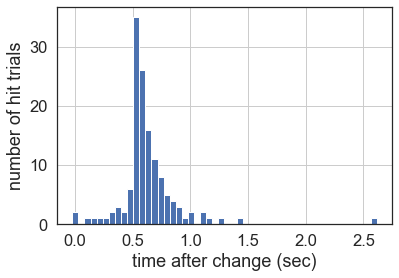

In [20]:
# plot histogram of response latencies
plt.hist(trials[trials['go']==True].response_latency.values, bins=50);
plt.ylabel('number of hit trials')
plt.xlabel('time after change (sec)')
plt.grid()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.2: Plot reward volumn over time during a session</b>

<p> 1) Use <code>calculate_reward_rate</code> function in <code>allensdk.brain_observatory.behavior.trial_processing</code> module to create a column <code>reward_rate</code> and <code>change_time</code> columns of the trials dataframe to plot reward rate over time. Remember to use <code>help(function_name)</code> to learn about how to use it.

<p> Was the mouse actively performing the task and earning rewards during the entire session? 
    
</div>

In [21]:
from allensdk.brain_observatory.behavior.trials_processing import calculate_reward_rate

In [22]:
trials['reward_rate'] = calculate_reward_rate(trials['response_latency'].values, 
                                              trials['start_time'], window = 1.5)

In [23]:
# remove behavioral trials that were aborted due to animal's premature licking
trials_sel = trials[trials['aborted']==False]

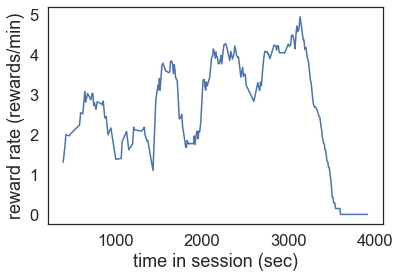

In [24]:
plt.plot(trials_sel['change_time'], trials_sel['reward_rate'])
plt.xlabel('time in session (sec)');
plt.ylabel('reward rate (rewards/min)');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.3: Compute and plot hit rate over time during a session</b>

<p> 1) Filter the trials dataframe to get the <code>hit</code> column for <code>go</code> trials only. Assign this to a new variable called <code>go_responses</code> for further analysis. <b>Note:</b> Make sure that you get <code>go_responses</code> as a pandas series, without calling <code>.values</code>, so that the next step will work properly. 
    
<p> The <code>hit</code> column of the trials dataframe contains <i>True</i> for all trials where there was a licking response within the 750ms reward window and <i>False</i> where there was not. 
       
</div>

In [25]:
# use .value_counts() compute total number of hits (True) and misses (False) in the go trials
trials[trials['go']==True]['hit'].value_counts()

True     110
False    107
Name: hit, dtype: int64

It's not uncommon for sessions to have more misses than hits. Not all mice do the task well during multiple days. It's also very common for mice to do the task well at the beginning of a session but not towards the end of a session. This trend is likely related to lack of motivation after receiving sufficient reward.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 2) Apply the pandas <code>rolling()</code> method to <code>go_responses</code> followed by <code>.mean()</code> to take a rolling mean across go trials. Set <code>window = 25, center = True</code> in the call to <code>rolling()</code> for a centered window over 25 trials. Set the output of this step to a variable called <code>rolling_hit_rate</code>. 

 __[Documentation for pandas.rolling()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)__
</div>

In [26]:
go_responses = trials[trials['go']==True]['hit']
rolling_hit_rate = go_responses.rolling(window=25, center=True).mean()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> 3) Plot the <code>rolling_hit_rate</code>. Label your axes.
       
</div>

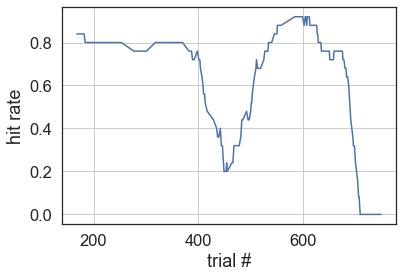

In [27]:
plt.plot(rolling_hit_rate)
plt.xlabel('trial #')
plt.ylabel('hit rate')
plt.grid()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.4: Plot the average hit rate for each image. Dislay presented stimuli.</b>

<p>1) Loop through the 8 images in this session and quantify the fraction of go trials where there was a correct response for each image to get the mean hit rate across the session. <b>Hint:</b> Use <code>ophys_experiment.trials.change_image_name.unique()</code> to get the image names.
        
</div>

In [28]:
# get the hit rate for each image
hit_rates = []
images = trials['change_image_name'].unique()
for image in images:
    image_change_trials = trials[(trials['change_image_name'] == image) & 
                                 (trials['go'] == True)]
    hit_rates.append(np.sum(image_change_trials['hit'])/len(image_change_trials))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>2) Plot the average hit rate for each image, with image names along the x-axis. 
    
<p> <b>Bonus:</b> Sort hit rate values in ascending order and apply the same sorting to the image names along the x-axis. Hint: Useful functions include np.sort() and np.argsort()
</div>

In [29]:
# sort the hit rates in ascending order and sort the image labels in the same order
hit_rates_sorted = np.sort(hit_rates)
sorted_order = np.argsort(hit_rates)
images_sorted = images[sorted_order]

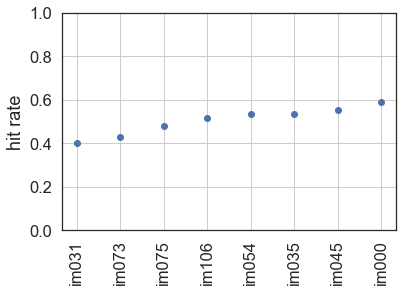

In [30]:
# plot hit rate by image with image names on the x-axis
fig, ax = plt.subplots()
plt.plot(hit_rates_sorted, 'o')
ax.set_xticks(np.arange(0,len(images_sorted),1));
ax.set_xticklabels(images_sorted, rotation=90);
ax.set_ylabel('hit rate');
ax.set_ylim(0,1);
ax.grid()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 3) Using <code>ophys_experiment.stimulus_template</code>, plot stimuli that were presented during this session.
</div>

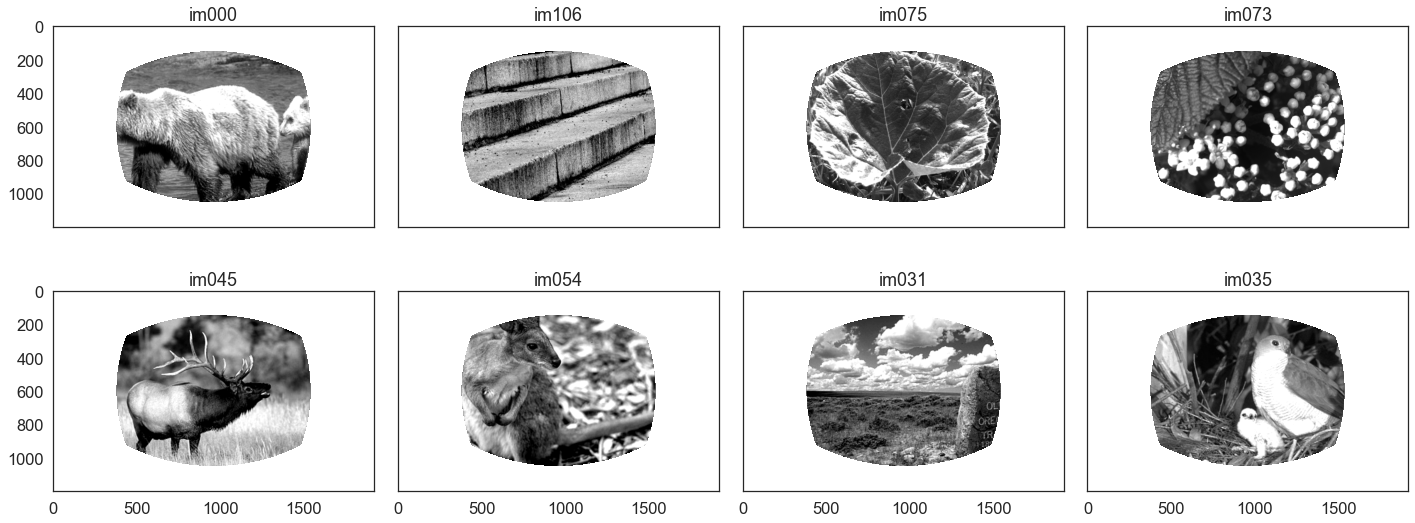

In [31]:
fig, ax = plt.subplots(2,4,figsize = (20,8), sharex = True, sharey=True)
for ii,image_name in enumerate(ophys_experiment.stimulus_templates.index):
    ax.flatten()[ii].imshow(ophys_experiment.stimulus_templates.loc[image_name]['unwarped'], cmap='gray')
    ax.flatten()[ii].set_title(image_name)
fig.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 1.5: Plot the correct response probability for all image transitions</b>

<p> The task cycles through 8 different images, resulting in 64 possible image transitions. Some image transitions might be easier for the mouse to detect than others. 

<p> 1) Use pandas <code>pivot_table()</code> on the trials table to count and average the <code>hit</code> values by <code>initial_image_name</code> as indices and <code>change_image_name</code> as columns. This will create a matrix of corrent response probability for all image transitions. 
    
 __[Documentation for pandas.pivot_table()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html)__ 
 
</div>

In [32]:
# use pivot table to make a matrix of respones probability
response_matrix = pd.pivot_table(trials,  
                                 values='hit', 
                                 index='initial_image_name',
                                 columns='change_image_name')
response_matrix

change_image_name,im000,im031,im035,im045,im054,im073,im075,im106
initial_image_name,,,,,,,,
im000,0.000000,0.666667,0.50,0.25,0.75,0.25,0.50,0.50
im031,0.666667,0.000000,0.50,0.50,0.50,0.75,0.50,0.25
im035,0.750000,0.500000,0.00,0.50,0.75,0.50,0.50,0.75
im045,0.500000,0.250000,0.50,0.00,0.25,0.25,0.50,0.50
im054,0.750000,0.250000,0.75,0.75,0.00,0.25,0.25,0.50
im073,0.500000,0.250000,0.75,0.75,0.25,0.00,0.75,0.25
im075,0.750000,0.250000,0.50,0.50,0.75,0.50,0.00,0.75
im106,0.250000,0.500000,0.25,0.50,0.50,0.50,0.25,0.00


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 2) Plot the hit transition matrix as a heatmap. Try using seaborn's heatmap function.

 __[Documentation for seaborn.heatmap()](https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap)__ 
    

<p> Did the mouse respond similarly for image changes compared to the same image repeated on catch trials? Are some image transitions more detectable than others? 

</div>

<AxesSubplot:xlabel='change_image_name', ylabel='initial_image_name'>

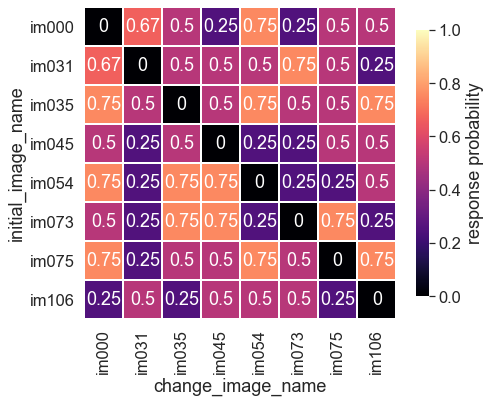

In [33]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(response_matrix, vmin=0, vmax=1, cmap='magma',
            square=True, annot=True, linewidths=0.01, cbar_kws={"shrink": 0.7, "label": 'response probability'}, ax=ax)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Bonus:</b> Plot response probability across image transitions for engaged trials only


<p> Filter out trials where the mouse wasn't reliably performing the task using the value of the <code>reward_rate</code> column, with a threshold of 2 rewards per minute to distinguish engaged from disengaged periods, then plot the transition heatmap again. 

<p> Does varying engagement influence how we should analyze neural activity?

</div>

<AxesSubplot:xlabel='change_image_name', ylabel='initial_image_name'>

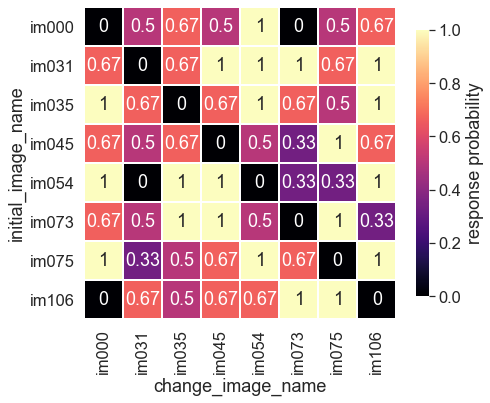

In [34]:
response_matrix = pd.pivot_table(trials[trials['reward_rate']>2],  
                                 values='hit', 
                                 index='initial_image_name',
                                 columns='change_image_name')

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(response_matrix, vmin=0, vmax=1, cmap='magma',
            square=True, annot=True, linewidths=0.01,
            cbar_kws={"shrink": 0.7, "label": 'response probability'}, ax=ax)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Single Cell Physiology Exercises</h2>
    
<p> These exercises explore neural activity aligned to stimulus trials. They make use of the <code>get_stimulus_response_df()</code> function and <code>stimulus_presentations</code> dataframe, as well as additional help functions in mindscope utilities that can add additional columns to stimulus_presentations dataframe with information about licks, rewards, mean pupil area or running speed. 

</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF;"
<p><b>Info about stimulus_presentations and stimulus_response dataframes</b>
    
<p> The <code>stimulus_presentations</code> contains metadata about each stimulus presentation in a given session. Additional steps are needed to add information about trials and animal behavior.
    
<p> The <code>stimulus_response_df</code> contains the response of each cell to each individual stimulus presentation during the session. 
    
<p> Both dataframes have a column called <code>trace</code> that contains a segment of each cell's fluorescence trace over a window of time. The duration of the window over which the <code>trace</code> was extracted can be specified in <code>get_stimulus_response</code> using <code>time_window</code> input variable. 
    
<p> If <code>compute_means</code> is True (default) in <code>get_stimulus_response</code>, you will have a column <code>mean_response</code> in the dataframe that contains each cell's response averaged over [0 time_window[1]] and <code>baseline_response</code> with pre stimulus activity mean.

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>While AllenSDK provides geat tools for loading Visual Behavior Dataset, for aligned neural responses you can find additional functions in <code>mindscope_utilities</code>module. </p>
    
<p>You can add the tools to your notebook by running:
<p><code> import mindscope_utilities</code></p>
<p><code>import mindscope_utilities.visual_behavior_ophys as ophys</code></p>

    
<p>For Visual Behavior specific questions, you can use <code>visual_behavior_ophys</code> module's:</p>

* <code>build_tidy_cell_df</code> 
* <code>get_stimulus_response_df</code>
* functions that add additional meta data to stimulus_presentations table such as <code>add_mean_pupil_area_to_stimulus_presentations</code>, etc.
    
<p>For general alinging of neural and behavioral traces to events:</p>
    
* <code>event_triggered_response</code>
    
    
 __[Documentation for mindscope_utilities()](https://github.com/AllenInstitute/mindscope_utilities)__ 

</div> 

In [35]:
import mindscope_utilities.visual_behavior_ophys as ophys


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.1: Plot neural activity during image changes using the stimulus response dataframe and stimulus_presentations</b>

<p> 1) Assign the output of <code>ophys.get_stimulus_response()</code> for image changes only to a variable called <code>stimulus_response</code>. Make sure to check out documentation for this function to learn how to use it. You can call <code>help(function_name)</code> or <code>function_name()?</code> to print documentation. Use <code>event_type</code> input option to subselect image changes only.

</div>

In [36]:
ophys.get_stimulus_response_df?

In [37]:
# get stimulus response dataframe, for 'dff' traces and only image changes
experiment_id = selected_experiments.index.values[4]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment, 
                                                     time_window = [-1, 1.5],
                                                     data_type = 'dff',
                                                     event_type = 'changes')

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.47it/s]


In [38]:
# print a few rows of stimulus response df to check it out
stimulus_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response
0,40,1086630543,"[0.18448559939861298, 0.058513579685022535, 0....","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",-0.063009,0.054968
1,40,1086630685,"[1.8183737993240356, 1.905273100822111, 1.6940...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",1.596872,1.573727
2,40,1086630937,"[0.08111092448234558, 0.12697672965198448, 0.0...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.047877,0.025447
3,40,1086631077,"[0.030042489990592003, 0.04962731379373422, 0....","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",-0.011008,0.014507
4,40,1086631138,"[0.8512143492698669, 1.0818633501334773, 1.050...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.897726,0.908595


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p> 2) Assign <code>ophys_experiment.stimulus_presentations</code> to a variable called <code>stimulus_presentations</code>. Use <code>.copy()</code> to make a copy of the dataframe in order to avoid accidently editing the original.

</div>

In [39]:
# get stimulus_presentations, print a few rows
stimulus_presentations = ophys_experiment.stimulus_presentations.copy()
stimulus_presentations.head()

,start_time,stop_time,duration,image_name,image_index,is_change,omitted,start_frame,end_frame,image_set
stimulus_presentations_id,,,,,,,,,,
0,308.44675,308.69695,0.25020,im000,0,False,False,17983,17998.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
1,309.19734,309.44754,0.25020,im000,0,False,False,18028,18043.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
2,309.94798,310.19816,0.25018,im000,0,False,False,18073,18088.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
3,310.69859,310.94881,0.25022,im000,0,False,False,18118,18133.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
4,311.44919,311.69943,0.25024,im000,0,False,False,18163,18178.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> 3) Use <code>.join()</code> method of pandas dataframe to merge <code>stimulus_presentations</code> onto <code>stimulus_response_df</code> using <code>stimulus_presentations_id</code> column as a key.  Pick a cell and get all change trials for that cell by filtering your new <code>stimulus_response_df</code> by both the <code>cell_specimen_id</code> column and the <code>is_change</code> column.
</div>

In [40]:
# merge stimulus response df with stimulus presentations to a new df
stimulus_response_df = stimulus_response_df.join(stimulus_presentations, on='stimulus_presentations_id')
# print to make sure the dfs merged
stimulus_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,start_time,stop_time,duration,image_name,image_index,is_change,omitted,start_frame,end_frame,image_set
0,40,1086630543,"[0.18448559939861298, 0.058513579685022535, 0....","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",-0.063009,0.054968,338.47119,338.72158,0.25039,im045,4,True,False,19783,19798.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
1,40,1086630685,"[1.8183737993240356, 1.905273100822111, 1.6940...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",1.596872,1.573727,338.47119,338.72158,0.25039,im045,4,True,False,19783,19798.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
2,40,1086630937,"[0.08111092448234558, 0.12697672965198448, 0.0...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.047877,0.025447,338.47119,338.72158,0.25039,im045,4,True,False,19783,19798.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
3,40,1086631077,"[0.030042489990592003, 0.04962731379373422, 0....","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",-0.011008,0.014507,338.47119,338.72158,0.25039,im045,4,True,False,19783,19798.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
4,40,1086631138,"[0.8512143492698669, 1.0818633501334773, 1.050...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.897726,0.908595,338.47119,338.72158,0.25039,im045,4,True,False,19783,19798.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14


In [41]:
# get change stimulus trials for one cell only
cell_specimen_ids = stimulus_response_df.cell_specimen_id.unique()
cell_specimen_id = cell_specimen_ids[5]

stimulus_response_df_sel = stimulus_response_df[stimulus_response_df['cell_specimen_id']==cell_specimen_id]
stimulus_response_df_sel.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,start_time,stop_time,duration,image_name,image_index,is_change,omitted,start_frame,end_frame,image_set
5,40,1086631205,"[0.37963053584098816, 0.49193811189788994, 0.3...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.414443,0.297814,338.47119,338.72158,0.25039,im045,4,True,False,19783,19798.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
30,55,1086631205,"[2.321849822998047, 2.1499817461731854, 2.1446...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",1.639384,1.969877,349.73038,349.98057,0.25019,im054,5,True,False,20458,20473.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
55,65,1086631205,"[1.934748649597168, 1.5581732227807181, 1.5793...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",1.184718,1.576513,357.23650,357.48667,0.25017,im045,4,True,False,20908,20923.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
80,75,1086631205,"[1.3410823345184326, 1.1837909407175868, 1.027...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.816106,1.150707,364.74264,364.99280,0.25016,im073,3,True,False,21358,21373.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14
105,89,1086631205,"[0.0484369620680809, 0.2051156334680567, 0.055...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.008184,0.085858,375.25116,375.50143,0.25027,im075,2,True,False,21988,22003.0,Natural_Images_Lum_Matched_set_ophys_6_2017.07.14


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> Get the values of the <code>trace</code> column from your selected dataframe. Loop through these values and plot the traces for all change trials. Set color='gray. 
    
<b>Bonus:</b> Plot with time relative to the stimulus onset, in seconds, on the x-axis. Hint: Use the <code>trace_timestamps</code> column to get time relative to stimulus onset for one stimulus presentation.
    
<p> 4) Take the mean of the <code>trace</code> values and plot the average response on the same figure as the individual trials, this time setting color='b'.

Does this cell have a reliable response to image changes? 

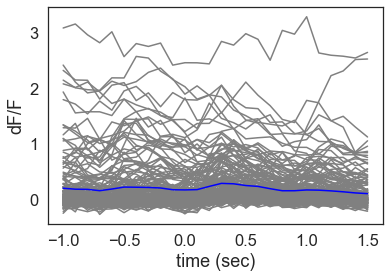

In [42]:
# plot for one cell
time_seconds = stimulus_response_df_sel.iloc[0]['trace_timestamps']

mean_trace = stimulus_response_df_sel['trace'].mean()

# loop through all trials and plot 
for trace in stimulus_response_df_sel['trace'].values: 
    plt.plot(time_seconds, trace, color='gray')
plt.xlabel('time (sec)')
plt.ylabel('dF/F')

# plot trace average
plt.plot(time_seconds, mean_trace, color='b');

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">   

<p> 5) Create this plot for multiple cells. How do different cells respond image changes?
    
<b>Bonus:</b> Plot multiple cells in one figure on different axes. Use <code>fig, ax = plt.subplots()</code> followed by <code>ax = ax.ravel()</code> to create iterable axes. 

 __[Documentation for matplotlib.pyplot.subplots()](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplots.html)__ 
    
 __[Why use fig, ax = plt.subplots() ? ](https://stackoverflow.com/questions/34162443/why-do-many-examples-use-fig-ax-plt-subplots-in-matplotlib-pyplot-python )__ 

</div>

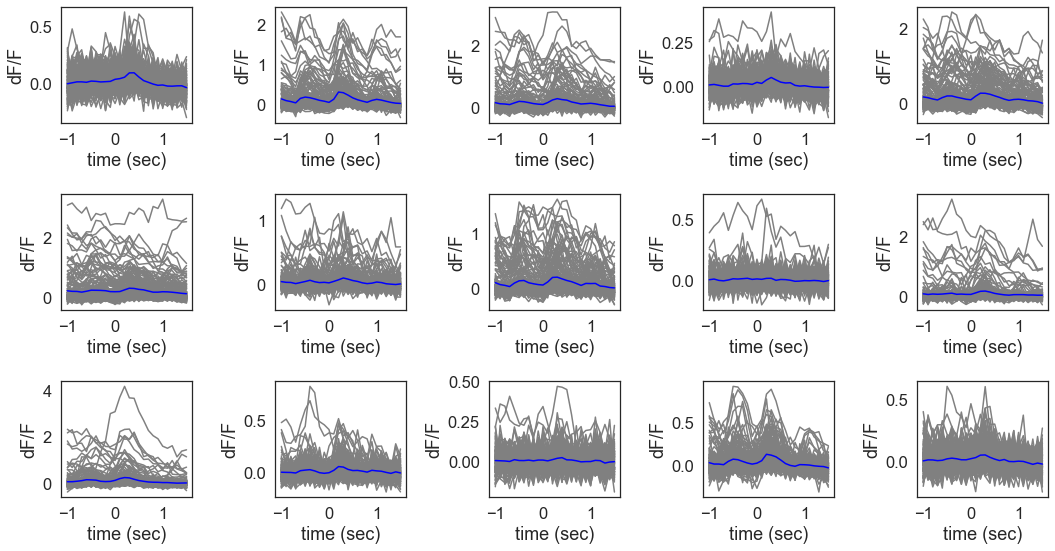

In [43]:
# plot for 15 cells
cell_specimen_ids = stimulus_response_df['cell_specimen_id'].unique()
fig, ax = plt.subplots(3,5, figsize=(15,8))
ax = ax.ravel()
if len(cell_specimen_ids) >=15:
    max_subplots = 15
else:
    max_subplots = len(cell_specimen_ids)
    
for i,cell_specimen_id in enumerate(cell_specimen_ids[:max_subplots]): 
    stimulus_response_df_sel = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) &
                                             (stimulus_response_df['is_change']==True)] # this line is redundant if you set event_type='changes'
    time_seconds = stimulus_response_df_sel.iloc[0]['trace_timestamps']
    mean_trace = np.mean(stimulus_response_df_sel['trace'].values)
    
    for trace in stimulus_response_df_sel['trace'].values: 
        ax[i].plot(time_seconds, trace, color='gray')
    ax[i].set_xlabel('time (sec)')
    ax[i].set_ylabel('dF/F')
    
    ax[i].plot(time_seconds, mean_trace, color='b')
fig.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.2: Correlate neural activity with running speed on a trial by trial basis</b>

<p> Trial to trial variability could arise from differences in animal behavior. One possibility is modulation by running speed. 

<p> 1) Pick a cell and select all presentations of one image. 
    
<p> 2) Create a scatterplot of running speed vs neural response magnitude using the <code>mean_response</code> in <code>stimulus_response_df</code> and <code>mean_running_speed</code> columns that can be added to <code>stimulus_presentations</code> dataframe using <code>add_mean_running_speed_to_stimulus_presentations</code>. 

<p> The <code>mean_running_speed</code> is the average of the running_speed trace during the 250ms stimulus presentation for each image presentation. 
    
</div>

In [44]:
# get stimulus response dataframe
experiment_id = selected_experiments.index.values[10]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)

# get stimulus response df for image presentations only (excluding omissions)
time_window = [-1, 1.5]
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment, 
                                                     time_window = time_window,
                                                     data_type = 'dff',
                                                     event_type = 'images')

# get stimulus_presentations
stimulus_presentations = ophys_experiment.stimulus_presentations.copy()


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [01:43<00:00,  2.96s/it]


In [45]:
# you can use the same time window to compute mean running speed as time window
# used for neural trace slicing. If you are not sure about what time widnow was used, you can use 
# trace timestamps to figure it out
time_window = [stimulus_response_df.loc[0]['trace_timestamps'].min(), 
               stimulus_response_df.loc[0]['trace_timestamps'].max()]

In [46]:
ophys.add_mean_running_speed_to_stimulus_presentations?

In [47]:
# add mean running speed
running_speed = ophys_experiment.running_speed.copy()
stimulus_presentations = ophys.add_mean_running_speed_to_stimulus_presentations(stimulus_presentations,
                                                                                  running_speed = running_speed,
                                                                                  time_window = time_window)

In [48]:
stimulus_presentations.head()

,start_time,stop_time,duration,image_name,image_index,is_change,omitted,start_frame,end_frame,image_set,mean_running_speed
stimulus_presentations_id,,,,,,,,,,,
0,6.86375,NaN,NaN,omitted,8,False,True,0,NaN,omitted,-0.016199
1,306.89099,307.14112,0.25013,im065,0,False,False,17987,18002.0,Natural_Images_Lum_Matched_set_training_2017.0...,16.674900
2,307.64153,307.89171,0.25018,im065,0,False,False,18032,18047.0,Natural_Images_Lum_Matched_set_training_2017.0...,11.841908
3,308.39214,308.64234,0.25020,im065,0,False,False,18077,18092.0,Natural_Images_Lum_Matched_set_training_2017.0...,8.571076
4,309.14275,309.39293,0.25018,im065,0,False,False,18122,18137.0,Natural_Images_Lum_Matched_set_training_2017.0...,12.090895


In [49]:
# merge stimulus_presentations with response df
stimulus_response_df = stimulus_response_df.join(stimulus_presentations, 
                                                on='stimulus_presentations_id')

In [50]:
stimulus_response_df.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,start_time,stop_time,duration,image_name,image_index,is_change,omitted,start_frame,end_frame,image_set,mean_running_speed
0,1,1086555190,"[0.05725036561489105, 0.01941195020858376, 0.0...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.262665,-0.034398,306.89099,307.14112,0.25013,im065,0,False,False,17987,18002.0,Natural_Images_Lum_Matched_set_training_2017.0...,16.6749
1,1,1086555432,"[0.019557110965251923, -0.04905771516223509, 0...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.471854,-0.052062,306.89099,307.14112,0.25013,im065,0,False,False,17987,18002.0,Natural_Images_Lum_Matched_set_training_2017.0...,16.6749
2,1,1086556416,"[-0.07086436450481415, 0.013648741461775566, -...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.141568,-0.029913,306.89099,307.14112,0.25013,im065,0,False,False,17987,18002.0,Natural_Images_Lum_Matched_set_training_2017.0...,16.6749
3,1,1086556696,"[-0.06124214082956314, -0.04559803939188162, 0...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.865761,-0.049455,306.89099,307.14112,0.25013,im065,0,False,False,17987,18002.0,Natural_Images_Lum_Matched_set_training_2017.0...,16.6749
4,1,1086557082,"[-0.15668746829032898, -0.05509244232173405, -...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.446151,-0.109187,306.89099,307.14112,0.25013,im065,0,False,False,17987,18002.0,Natural_Images_Lum_Matched_set_training_2017.0...,16.6749


In [51]:
# get ids of cells in this experiment
cell_specimen_ids = stimulus_response_df['cell_specimen_id'].unique()


In [52]:
# select one cell
cell_specimen_id = cell_specimen_ids[4]

# select response of the cell to one image type
stimulus_response_df_sel = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) & 
                                         (stimulus_response_df['image_index']==0)]
stimulus_response_df_sel.head()

,stimulus_presentations_id,cell_specimen_id,trace,trace_timestamps,mean_response,baseline_response,start_time,stop_time,duration,image_name,image_index,is_change,omitted,start_frame,end_frame,image_set,mean_running_speed
4,1,1086557082,"[-0.15668746829032898, -0.05509244232173405, -...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.446151,-0.109187,306.89099,307.14112,0.25013,im065,0,False,False,17987,18002.0,Natural_Images_Lum_Matched_set_training_2017.0...,16.674900
39,2,1086557082,"[-0.12111367285251617, -0.030962278605456764, ...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.501740,0.286025,307.64153,307.89171,0.25018,im065,0,False,False,18032,18047.0,Natural_Images_Lum_Matched_set_training_2017.0...,11.841908
74,3,1086557082,"[0.6819882392883301, 0.5629186974852907, 0.212...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.551597,0.516652,308.39214,308.64234,0.25020,im065,0,False,False,18077,18092.0,Natural_Images_Lum_Matched_set_training_2017.0...,8.571076
109,4,1086557082,"[0.8497451543807983, 0.16382842565330352, 0.13...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",0.843480,0.416696,309.14275,309.39293,0.25018,im065,0,False,False,18122,18137.0,Natural_Images_Lum_Matched_set_training_2017.0...,12.090895
144,5,1086557082,"[0.41971808671951294, 0.4086626621221876, 0.21...","[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.399999...",1.052921,0.599530,309.89334,310.14358,0.25024,im065,0,False,False,18167,18182.0,Natural_Images_Lum_Matched_set_training_2017.0...,12.410978


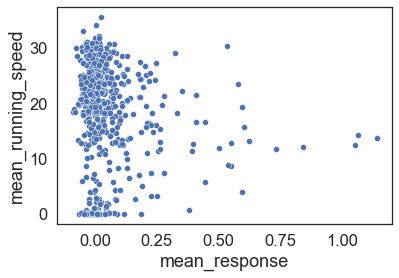

In [53]:
# plot scatter plot of mean response vs. running speed
fig, ax = plt.subplots()
ax = sns.scatterplot(data=stimulus_response_df_sel, x='mean_response', y='mean_running_speed', ax=ax)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 2) Compute the Pearson correlation between the image-trial-wise <code>mean_response</code> and <code>mean_running_speed</code> using <code>scipy.stats.pearsonr()</code>. Is there a correlation? 

</div>

In [54]:
# get pearson correlation 
import scipy.stats as st
r, p = st.pearsonr(stimulus_response_df_sel['mean_response'].values, stimulus_response_df_sel['mean_running_speed'].values)
print('r = ', np.round(r,3), 'p = ', np.round(p,3))

r =  -0.143 p =  0.0


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> <b>Bonus:</b> Compute the running correlation for all cells in the session and plot a histogram of the values. 

</div>

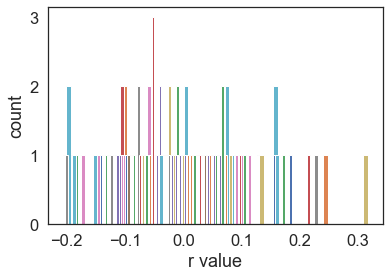

In [55]:
# get pearson correlation values for all cells
fig, ax = plt.subplots(1,1)
image_numbers = stimulus_response_df['image_index'].unique()
for cell_specimen_id in cell_specimen_ids:
    r_values = []
    for image_number in image_numbers:
        tmp = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) & 
                                                 (stimulus_response_df['image_index']==image_number)]
        r, p = st.pearsonr(tmp['mean_response'].values, tmp['mean_running_speed'].values)
        r_values.append(r)
        
    ax.hist(r_values, bins=50);
    ax.set_xlabel('r value');
    ax.set_ylabel('count');
    
    

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 3) You can also binarize running speed into running and sitting trials. You can plot an average image response when the animals are running or sitting still. 
</div>


In [56]:
cell_specimen_id = cell_specimen_ids[6]

# select response of the cell to one image type
stimulus_response_df_sel = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id)]

Text(0, 0.5, 'count')

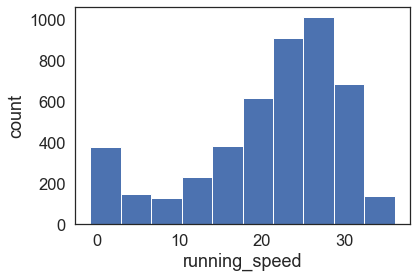

In [57]:
plt.hist(stimulus_response_df_sel['mean_running_speed'].values)
plt.xlabel('running_speed')
plt.ylabel('count')

In [58]:
# binarize
stimulus_response_df_sel.loc[stimulus_response_df_sel['mean_running_speed'] > 10,'running_binary'] = 'running'
stimulus_response_df_sel.loc[stimulus_response_df_sel['mean_running_speed'] <= 10,'running_binary'] = 'sitting'

C:\Users\iryna.yavorska\Anaconda3\envs\neuromatch\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\iryna.yavorska\Anaconda3\envs\neuromatch\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [59]:
stimulus_response_df_sel['running_binary'].value_counts()

running    3977
sitting     640
Name: running_binary, dtype: int64

<AxesSubplot:xlabel='image_index', ylabel='mean_response'>

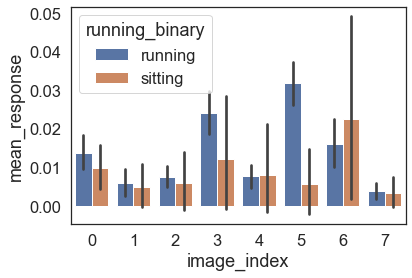

In [60]:
sns.barplot(data=stimulus_response_df_sel,
            x='image_index',
            y = 'mean_response',
            hue = 'running_binary')

Looks like although individual cells may not show strong correlation with running speed, population activity is modulated by animal's movements. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.3: Plot the image averaged response across changes for one or all cells using the simulus response dataframe. Examine pupil size effect on change responses.</b>
   
<p> 1) Using <code>get_stimulus_response_df</code> with stimuluse presentation to plot average responses to images that are non-changes and changes. Do images elicit a different response on the first presentation?

</div>

In [61]:
# get stimulus response dataframe
experiment_id = selected_experiments.index.values[5]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)

# get stimulus response df for image presentations only (excluding omissions)
time_window = [-1, 1.5]
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment, 
                                                     time_window = time_window,
                                                     data_type = 'dff',
                                                     event_type = 'images')

# get stimulus_presentations
stimulus_presentations = ophys_experiment.stimulus_presentations.copy()

C:\Users\iryna.yavorska\Anaconda3\envs\neuromatch\lib\site-packages\allensdk\brain_observatory\behavior\session_apis\data_transforms\behavior_ophys_data_transforms.py:189: UserWarning: Monitory delay calculation failed with ValueError
    "operands could not be broadcast together with shapes (4500,) (4501,) "
looking monitor delay up from table for rig: CAM2P.3 
delay: 0.02139 seconds
  warnings.warn(warning_msg)
100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:55<00:00,  3.06s/it]


In [62]:
#append stimulus presentation information to response df
stimulus_response_df = stimulus_response_df.join(stimulus_presentations, 
                                                on='stimulus_presentations_id')

<AxesSubplot:xlabel='image_name', ylabel='mean_response'>

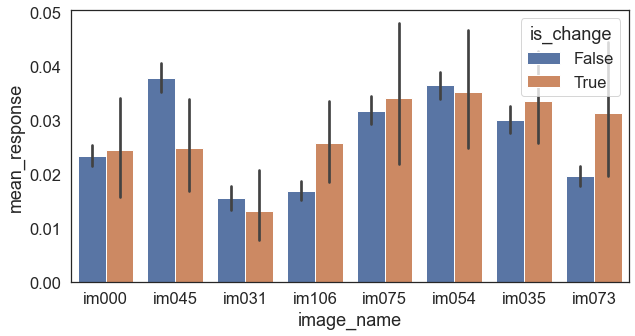

In [63]:
fig, ax = plt.subplots(1,1, figsize =(10,5))
sns.barplot(data = stimulus_response_df, 
             y ='mean_response',
             x = 'image_name',
             hue = 'is_change')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p> 2) Are there differences in mean pupil size during non-change vs change stimulus presentations? Use <code>ophys.add_mean_pupil_area_to_stimulus_presentations</code> to add mean pupil area to the stimulus presentations dataframe

</div>

In [64]:
eye_tracking = ophys_experiment.eye_tracking
stimulus_presentations = ophys.add_mean_pupil_area_to_stimulus_presentations(stimulus_presentations, 
                                                                                eye_tracking,
                                                                                time_window = [0, 1.5])

In [65]:
#append mean_pupil_area information to response df
stimulus_response_df = stimulus_response_df.join(stimulus_presentations[['mean_pupil_area']], 
                                                on='stimulus_presentations_id')

<AxesSubplot:xlabel='image_name', ylabel='mean_pupil_area'>

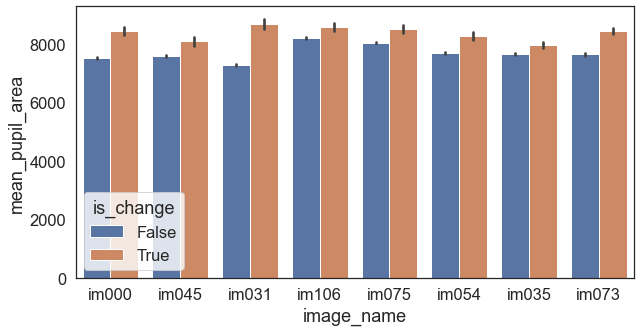

In [66]:
fig, ax = plt.subplots(1,1, figsize =(10,5))
sns.barplot(data = stimulus_response_df, 
             y ='mean_pupil_area',
             x = 'image_name',
             hue = 'is_change')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p> 3) Plot the average <code>trace</code> across stimulus presentations for one cell per image, with a shaded color indicating pupil size. Plot the x-axis in seconds relative to the <code>change_time</code>. <b>Hint:</b> Use max normalized <code>mean_pupil_area</code> when specifying line color.

In [67]:
# subselect stimulus response df for one cell
cell_specimen_ids = stimulus_response_df['cell_specimen_id'].unique()
cell_specimen_id = cell_specimen_ids[2]

stimulus_response_df_sel = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id)] 


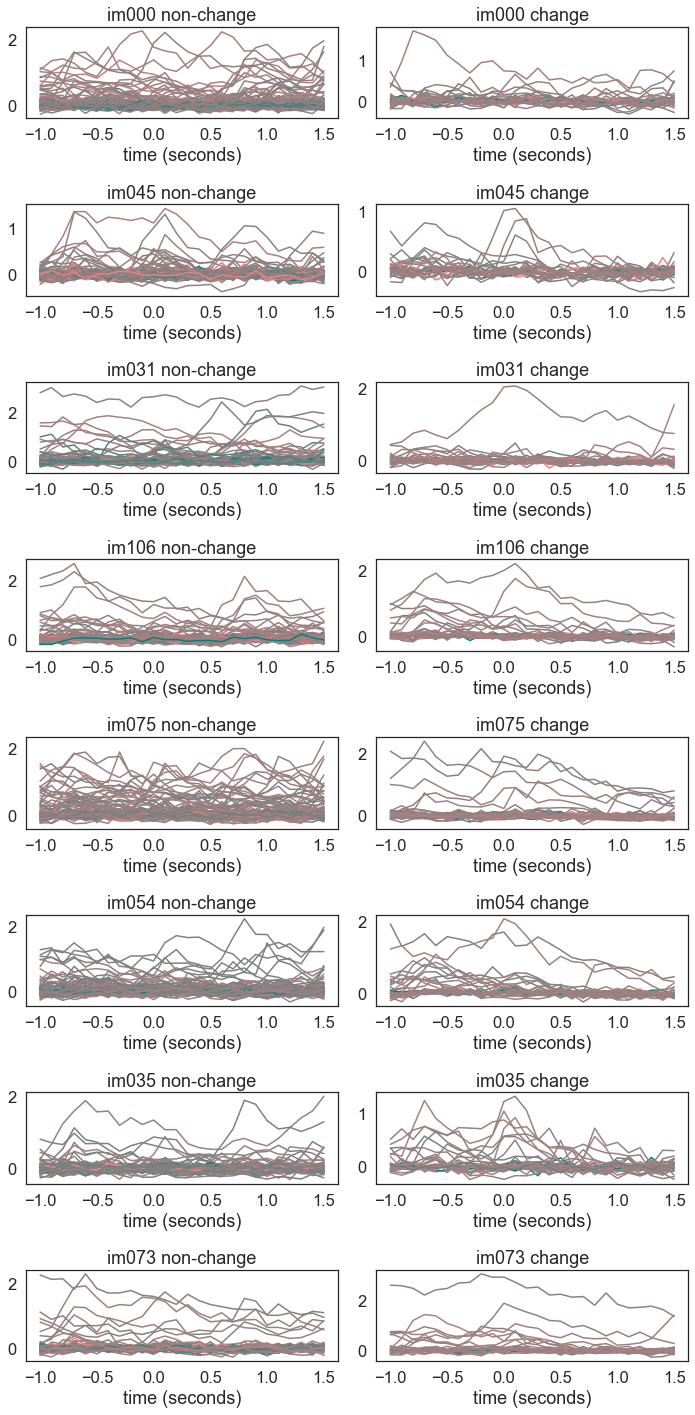

In [68]:

image_names = stimulus_response_df_sel['image_name'].unique()
fig, ax  = plt.subplots(len(image_names),2, figsize = (10,20))
timestamps = stimulus_response_df_sel.iloc[0]['trace_timestamps']
max_pupil_area = stimulus_response_df_sel['mean_pupil_area'].max()
for i,image_name in enumerate(image_names):
    tmp = stimulus_response_df_sel[(stimulus_response_df_sel['image_name']==image_name) &
                                  (stimulus_response_df_sel['is_change']==False)]
    all_trials = np.arange(0, tmp.shape[0])
    random_trials = np.random.choice(len(all_trials), size=100, replace=False)
    for t in random_trials:
        trace = tmp.iloc[t]['trace']
        pupil_area = tmp.iloc[t]['mean_pupil_area']
        ax[i,0].plot(timestamps, trace, color = [pupil_area/max_pupil_area, .5, .5])
    ax[i,0].set_title(image_name + ' non-change')
    ax[i,0].set_xlabel('time (seconds)')
    tmp = stimulus_response_df_sel[(stimulus_response_df_sel['image_name']==image_name) &
                                  (stimulus_response_df_sel['is_change']==True)]
    
    for t in range(0, tmp.shape[0]):
        trace = tmp.iloc[t]['trace']
        pupil_area = tmp.iloc[t]['mean_pupil_area']
        ax[i,1].plot(timestamps, trace, color = [pupil_area/max_pupil_area, .5, .5])
    ax[i,1].set_title(image_name + ' change')
    ax[i,1].set_xlabel('time (seconds)')
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
 
<p> 4) Loop through the 8 images shown in this session and plot the average response for each image when it changes for one cell as a function of reward rate. Hint: use <code>add_reward_rate_to_stimulus_presentations</code> to add reward date to <code>stimulus_presentations</code>, then merge it onto <code>stimulus_response_df</code>
    
<p><b>Bonus:</b> Make the same plots but instead of plotting absolute mean responses, plot mean responses that are relative to the baseline response. Use <code>baseline_response</code> as your reference point. 
    
</div>

In [69]:
# get stimulus response dataframe
experiment_id = selected_experiments.index.values[5]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)

# get stimulus response df for image presentations only (excluding omissions)
time_window = [-1, 1.5]
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment, 
                                                     time_window = time_window,
                                                     data_type = 'dff',
                                                     event_type = 'images')


C:\Users\iryna.yavorska\Anaconda3\envs\neuromatch\lib\site-packages\allensdk\brain_observatory\behavior\session_apis\data_transforms\behavior_ophys_data_transforms.py:189: UserWarning: Monitory delay calculation failed with ValueError
    "operands could not be broadcast together with shapes (4500,) (4501,) "
looking monitor delay up from table for rig: CAM2P.3 
delay: 0.02139 seconds
  warnings.warn(warning_msg)
100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:53<00:00,  2.96s/it]


In [70]:
# load stimulus_presentations
stimulus_presentations = ophys_experiment.stimulus_presentations.copy()
eye_tracking = ophys_experiment.eye_tracking
stimulus_presentations = \
    ophys.add_mean_pupil_area_to_stimulus_presentations(stimulus_presentations, 
                                                                                eye_tracking,
                                                                               time_window = [0, 1.5])

In [78]:
def add_reward_rate_to_stimulus_presentations(trials, stimulus_presentations):
    '''
    Parameters:
    ____________
    trials_df: Pandas.DataFrame
        ophys_experiment.trials
    stimulus_presentations_df: Pandas.DataFrame
        ophys_experiment.stimulus_presentations

    Returns:
    ___________
    stimulus_presentations_df: Pandas.DataFrame
        with 'reward_rate' column
    '''

    last_time = 0
    reward_rate_by_frame = []
    trials['reward_rate'] = calculate_reward_rate(trials['response_latency'].values,
                                                     trials['start_time'], window=.5)

    trials = trials[trials['aborted'] == False]
    for change_time in trials.change_time.values:
        reward_rate = trials[trials.change_time ==
                                change_time].reward_rate.values[0]
        for start_time in stimulus_presentations.start_time:
            if (start_time < change_time) and (start_time > last_time):
                reward_rate_by_frame.append(reward_rate)
                last_time = start_time
    # fill the last flashes with last value
    for i in range(len(stimulus_presentations) - len(reward_rate_by_frame)):
        reward_rate_by_frame.append(reward_rate_by_frame[-1])
    stimulus_presentations['reward_rate'] = reward_rate_by_frame

    return stimulus_presentations

In [79]:
trials = ophys_experiment.trials.copy()
#stimulus_presentations = ophys.add_reward_rate_to_stimulus_presentations(trials, stimulus_presentations)

stimulus_presentations = add_reward_rate_to_stimulus_presentations(trials, stimulus_presentations)


In [80]:
stimulus_response_df = stimulus_response_df.join(stimulus_presentations, 
                                                on='stimulus_presentations_id')

Text(0.5, 1.0, 'response to change')

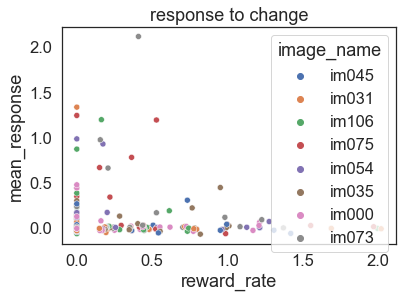

In [81]:
cell_specimen_id = cell_specimen_ids[2]

stim_reward_df = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) & 
                                 (stimulus_response_df['is_change']==True)]
ax = sns.scatterplot(data = stim_reward_df, 
                x = 'reward_rate', 
                y = 'mean_response',
                hue = 'image_name')
ax.set_title('response to change')

In [82]:
# make a new column with subtracted baseline response
stimulus_response_df['response_mean_rel'] = stimulus_response_df['mean_response'] - \
                                            stimulus_response_df['baseline_response']


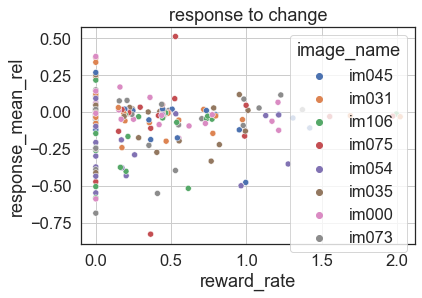

In [83]:
stim_reward_df = stimulus_response_df[(stimulus_response_df['cell_specimen_id']==cell_specimen_id) & 
                                 (stimulus_response_df['is_change']==True)]
ax = sns.scatterplot(data = stim_reward_df, 
                x = 'reward_rate', 
                y = 'response_mean_rel',
                hue = 'image_name')
ax.set_title('response to change')
ax.grid()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Exercise 2.4: Create a heatmap of all cells' trial averaged responses following an image change</b>

<p>From <code>stimulus_response_df</code>, use <code>mean()</code> method to take an average of response traces (n_samples) for each cell and add them to a new pandas dataframe with three columns: cell_specimen_id, mean_trace, trace_timestamps. Or create a response matrix of n_cells by n_timestamps.
       
<p>Sort responses using <code>np.argsort</code> before plotting to reveal any temporal structure in mean responses to changes
    
</div>

In [84]:
experiment_id = selected_experiments.index.values[9]
ophys_experiment = cache.get_behavior_ophys_experiment(experiment_id)
stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment,
                                                     event_type = 'changes')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.83it/s]


In [85]:
cell_specimen_ids = stimulus_response_df['cell_specimen_id'].unique()

mean_df = pd.DataFrame(columns = {'cell_specimen_id',
                                 'mean_trace',
                                 'trace_timestamps'})
timestamps = stimulus_response_df.iloc[0]['trace_timestamps']
for cell_specimen_id in cell_specimen_ids:
    tmp = stimulus_response_df[stimulus_response_df['cell_specimen_id']==cell_specimen_id]
    mean_df = mean_df.append({'cell_specimen_id': cell_specimen_id,
                    'mean_trace': tmp['trace'].mean(),
                    'trace_timestamps': timestamps},
                     ignore_index=True )

In [86]:
# create a response matrix
response_matrix = mean_df.mean_trace.values
response_matrix = np.stack(response_matrix, axis=0)
response_matrix.shape


(4, 61)

In [87]:
# sort cells in descending order
order = np.argsort(np.max(response_matrix,1))
response_matrix_sorted = response_matrix[order,:]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p> 4) Plot a heatmap of all cells' mean trace for their preferred image. Set the vmax of the heatmap equal to the 95% percentile value of the response array using <code>np.percentile()</code>. Set vmin to 0. 
    
 __[Documentation for numpy.percentile()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html)__ 

<p> What structure do you see in this population? Bonus: Sort the cells to help see structure in the data.



</div>

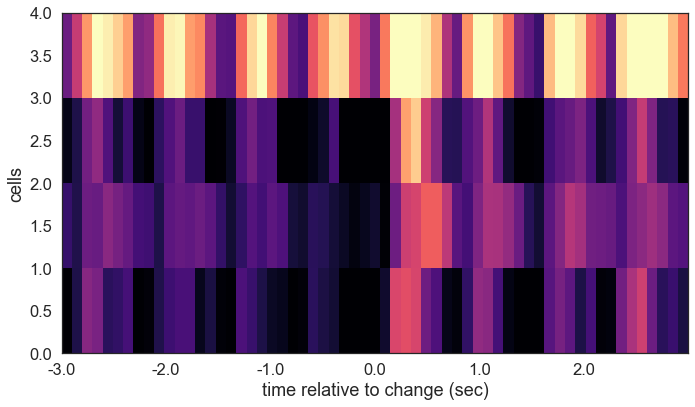

In [96]:


# create the plot
fig, ax = plt.subplots(figsize=(10,6))
ax.pcolormesh(response_matrix_sorted, cmap='magma', vmin=0, vmax=np.percentile(response_matrix, 95))
ax.set_ylabel('cells')

# set xticks and xticklabels
xticklabels = np.arange(timestamps[0], timestamps[-1])
steps = response_matrix.shape[1]/len(xticklabels)
ax.set_xticks(np.arange(0, response_matrix.shape[1], steps))
ax.set_xticklabels(np.arange(timestamps[0], timestamps[-1]))
ax.set_xlabel('time relative to change (sec)');
fig.tight_layout()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2> Across Session Physiology Exercises</h2>
    
<p> These exercises show how to aggregate data across sessions from the same imaging plane (aka from the same container) and match cells across multiple days. You will also learn how to compare different imaging planes across multiple brain regions and depths collected in the same session. They make use of the <code>get_stimulus_response_df</code> function and the <code>event_triggered_response</code> functions provided by the <code>mindscope_utilities</code> package. </p>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p><b>Exercise 3.1: Get stimulus aligned responses for all experiments in a container from a Vip mouse </p></b>
<p> 1) Select an <code>ophys_container_id</code> for a Vip mouse</p>
<p> 2.0) Create an empty dataframe called <code>container_response_df</code></p>
<p> 2.1) Loop through all ophys_experiment_ids in your selected <code>ophys_container_id</code></p>
<p> 2.2) Create a <code>stimulus_response_df</code> for each <code>ophys_experiment</code></p>
<p> 2.3) Merge the <code>stimulus_presentations</code> table for that ophys_experiment with the stimulus_response_df</p>
<p> 2.4) Add a column for <code>ophys_experiment_id</code> to each <code>stimulus_response_df</code> before concatenating so you can keep track of which experiment the cells are in</p>
<p> 2.5) With each loop, concatenate the <code>stimulus_response_df</code> to get a single <code>container_response_df</code></p>
<p> Note: This will take a few minutes    
</div>

In [97]:
# get ophys_experiment_table
ophys_experiment_table = cache.get_ophys_experiment_table()
# get Vip containers
vip_containers = ophys_experiment_table[ophys_experiment_table['cre_line']=='Vip-IRES-Cre'].ophys_container_id.unique()
# pick a container
vip_container_id = vip_containers[9]
# get the data for that container
vip_container = ophys_experiment_table[ophys_experiment_table.ophys_container_id==vip_container_id]
# get list of ophys_experiment_ids for that ophys_container_id
ophys_experiment_ids = vip_container.index.values

In [98]:
# loop through the ophys_experiment_ids and load each one, create a stimulus_response_df for it, 
# then concatenate all stimulus_response_dfs to make a single df for the full container
# make sure to add a column for ophys_experiment_id to the stimulus_response_df so that you can identify unique experiments

# create empty dataframe to collect all experiment stimulus_response_dfs in
container_response_df = pd.DataFrame()
for ophys_experiment_id in ophys_experiment_ids: 
    # get the ophys_experiment dataset
    ophys_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id)
    # pass it to the get_stimulus_respose_df utilities function to get stimulus aligned traces
    stimulus_response_df = ophys.get_stimulus_response_df(ophys_experiment)
    # merge stimulus_presentations into stimulus_response_df so that you have stimulus metadata to filter on
    stimulus_response_df = stimulus_response_df.merge(ophys_experiment.stimulus_presentations, on='stimulus_presentations_id')
    # add ophys_experiment_id to keep track of each unique experiment
    stimulus_response_df['ophys_experiment_id'] = ophys_experiment_id
    # concatinate with full container df to collect all experiments for this container
    container_response_df = pd.concat([container_response_df, stimulus_response_df])

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.06s/it]


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p><b>Exercise 3.2: Plot population average omission response across all experiments in a container </p></b>
<p> 1) Subselect omissions only from <code>container_response_df</code>, loop through <code>ophys_experiment_ids</code> when plotting data from an ophys experiment.</p>
</div>

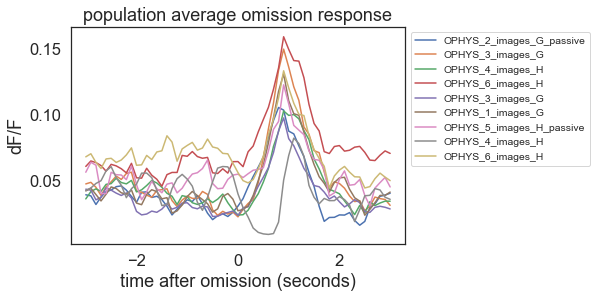

In [99]:
# get just the omission responses
omission_response_df = container_response_df[container_response_df.omitted==True]

# loop through experiments and plot averages
for ophys_experiment_id in ophys_experiment_ids: 
    # get session_type for this ophys_experiment_id
    session_type = ophys_experiment_table.loc[ophys_experiment_id].session_type
    # get cell response data for this ophys_experiment_id
    expt_data = omission_response_df[omission_response_df.ophys_experiment_id==ophys_experiment_id]
    # get mean response across all omissions, and timestamps, then plot
    mean_response = expt_data.trace.mean()
    timestamps = expt_data.trace_timestamps.values[0] # timestamps are the same for all traces
    plt.plot(timestamps, mean_response, label=session_type)
    plt.xlabel('time after omission (seconds)')
    plt.ylabel('dF/F')
    plt.title('population average omission response')
plt.legend(fontsize='xx-small', bbox_to_anchor=(1,1))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p><b>Exercise 3.3: Plot population average change response across all experiments in a container </p></b>
<p> 1) Repeat above for changes only. </p>    
</div>

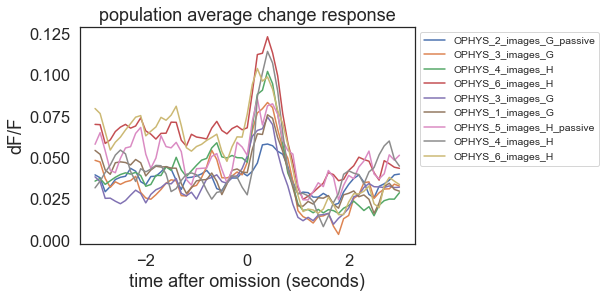

In [100]:
# get just the omission responses
change_response_df = container_response_df[container_response_df.is_change==True]

# loop through experiments and plot averages
for ophys_experiment_id in ophys_experiment_ids: 
    # get session_type for this ophys_experiment_id
    session_type = ophys_experiment_table.loc[ophys_experiment_id].session_type
    # get cell response data for this ophys_experiment_id
    expt_data = change_response_df[change_response_df.ophys_experiment_id==ophys_experiment_id]
    # get mean response across all omissions, and timestamps, then plot
    mean_response = expt_data.trace.mean()
    timestamps = expt_data.trace_timestamps.values[0] # timestamps are the same for all traces
    plt.plot(timestamps, mean_response, label=session_type)
    plt.xlabel('time after omission (seconds)')
    plt.ylabel('dF/F')
    plt.title('population average change response')
plt.legend(fontsize='xx-small', bbox_to_anchor=(1,1))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p><b>Exercise 3.4: Plot the average omission response for a single cell across all experiments in a container. </p></b>
<p> 3) Identify all the <code>cell_specimen_ids</code> for this container using the <code>ophys_cells_table</code> from <code>VisualBehaviorOphysProjectCache</code></p>
<p> 4) Determine how many <code>ophys_experiment_ids</code> each <code>cell_specimen_id</code> was matched in. </p>
<p> 5) Pick a cell that is in more than 4 experiments.</p>
<p> 6) Using the <code>container_response_df</code> you created, plot the average response following stimulus omissions for your selected cell across all ophys_experiment_ids it was matched in. </p>
<p> 7) Label the average response for each ophys_experiment_id with the <code>ophys_experiment_id</code> or the <code>session_type</code> for that experiment.</p>
</div>

In [101]:
# determine how how many ophys_session_ids each cell was matched in
# get ophys_cells_table
ophys_cells_table = cache.get_ophys_cells_table()
# merge with ophys_experiment_table to get metadata for all cells
ophys_cells_table = ophys_cells_table.merge(ophys_experiment_table, on='ophys_experiment_id')
# limit to container of interest
container_cells_table = ophys_cells_table[ophys_cells_table.ophys_container_id==vip_container_id]

In [102]:
# group by cell_specimen_id to count the number of ophys_experiment_ids per cell, only keep the ophys_experiment_id column
n_expts_matched = container_cells_table.groupby(['cell_specimen_id']).count()[['ophys_experiment_id']]
# how many experiments is each cell matched in? 
n_expts_matched

,ophys_experiment_id
cell_specimen_id,
1120077927,8
1120078139,1
1120078299,9
1120078430,9
1120078578,9
1120078802,1
1120078893,8
1120079144,7
1120079362,9


In [103]:
# filter to get cell_specimen_ids with at least 4 ophys_experiment_ids
vip_cells_matched_in_more_than_4_sessions = n_expts_matched[n_expts_matched.ophys_experiment_id>4].index.values
# pick some cell
selected_cell_specimen_id = vip_cells_matched_in_more_than_4_sessions[2]

In [104]:
# limit container_response_df just to omissions
omitted_responses = container_response_df[container_response_df.omitted==True]

In [105]:
# responses just for one cell
cell_responses = omitted_responses[omitted_responses.cell_specimen_id==selected_cell_specimen_id]

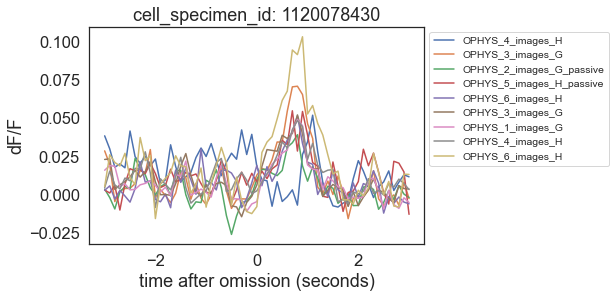

In [106]:
ophys_experiment_ids_for_this_cell = container_cells_table[container_cells_table.cell_specimen_id==selected_cell_specimen_id].ophys_experiment_id.unique()
for ophys_experiment_id in ophys_experiment_ids_for_this_cell: 
    # get session_type for this ophys_experiment_id
    session_type = ophys_experiment_table.loc[ophys_experiment_id].session_type
    # get cell response data for this ophys_experiment_id
    expt_data = cell_responses[cell_responses.ophys_experiment_id==ophys_experiment_id]
    # get mean response across all omissions, and timestamps, then plot
    mean_response = expt_data.trace.mean()
    timestamps = expt_data.trace_timestamps.values[0] # timestamps are the same for all traces
    plt.plot(timestamps, mean_response, label=session_type)
    plt.xlabel('time after omission (seconds)')
    plt.ylabel('dF/F')
    plt.title('cell_specimen_id: '+str(selected_cell_specimen_id))
plt.legend(fontsize='xx-small', bbox_to_anchor=(1,1))

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p><b>Exercise 3.5: Plot the average response across all imaging planes in a single Multiscope session </p></b>
<p> Using neuromatch example </p>
<p> Add instructions here </p>
</div>

In [107]:
# get ophys_session_table
ophys_session_table = cache.get_ophys_session_table()
# get Sst sessions
sst_sessions = ophys_session_table[(ophys_session_table.cre_line=='Sst-IRES-Cre')&
                                   (ophys_session_table.project_code=='VisualBehaviorMultiscope')]
# pick a session
ophys_session_id = sst_sessions.index[6]

In [108]:
# import tool to show progress bar
from tqdm import tqdm

In [109]:
# create a dictionary to save all the ophys_experiments into
ophys_experiments = {}
# get ophys_experiment_ids for this ophys_session_id
ophys_experiment_ids = sst_sessions.loc[ophys_session_id]['ophys_experiment_id']
# loop through ophys_experiment_ids
for ophys_experiment_id in tqdm(ophys_experiment_ids):
    # get the ophys_experiment dataset from the cache for each ophys_experiment_id
    ophys_experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 33.84it/s]


In [115]:
ophys_experiment_id

951980477

In [114]:
this_experiment.dff_traces

,cell_roi_id,dff
cell_specimen_id,,
NaN,1080744263,"[0.5661285519599915, 0.649069607257843, 0.1656..."
NaN,1080744267,"[0.6381154656410217, 0.4693359434604645, 0.214..."
NaN,1080744272,"[0.2404424399137497, 0.16355746984481812, 0.01..."
NaN,1080744273,"[0.20034287869930267, 0.13758832216262817, 0.0..."
NaN,1080744276,"[0.37228408455848694, 0.19270947575569153, 0.0..."
NaN,1080744282,"[0.44001835584640503, 0.19184070825576782, 0.1..."
NaN,1080744288,"[0.5760135054588318, 0.21791505813598633, 0.36..."
NaN,1080744294,"[0.3356594145298004, 0.10007178783416748, 0.09..."
NaN,1080744302,"[0.0813496857881546, 0.14040181040763855, 0.09..."


In [ ]:
# now loop through experiments and build a tidy dataframe with activity of all cells in the session
session_tidy_df = []
for ophys_experiment_id in tqdm(ophys_experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = ophys_experiments[ophys_experiment_id]
    this_experiment_tidy_df = ophys.build_tidy_cell_df(this_experiment)
    # add the ophys_experiment_id as a column so we can join with metadata tables later
    this_experiment_tidy_df['ophys_experiment_id'] = ophys_experiment_id
   
    # append the data for this experiment to a list
    session_tidy_df.append(this_experiment_tidy_df)
    
# concatate the list of dataframes into a single dataframe
session_tidy_df = pd.concat(session_tidy_df)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p>1) Calculate the mean response for each of the individual imaging planes in this experiment</p>
    
<p> By iterating over experiment IDs, we can also calculate the mean response for each of the 6 imaging planes. Do Sst cells in different visual areas respond to omissions in a distinct way?</p>

<p>We will first use a Pandas groupby and mean operations to get the mean timeseries for each cell in that imaging plane:</p>
</div>

In [ ]:
mean_dff_by_experiment = (
    session_tidy_df
    .groupby(['ophys_experiment_id','timestamps'])['dff']
    .mean()
    .reset_index()
)

In [ ]:
mean_dff_by_experiment.head()

We can then iterate over our 6 experiment IDs and use our make_event_triggered_plot wrapper function to calculate and plot the omission triggered response for that imaging plane:


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
<p> 2) Create an event triggered response dataframe relative to omissions</p>
<p>If we want to see how a given cell responds when regularly flashed stimuli are omitted, we can calculate the response around each of the stimulus omissions. The mindscope_utilities package has a convenience function to do this. We give the function:

* a dataframe of interest (containing activity from one cell)
* the t and y values of interest
* the event times
* how much time before and after each event we are interested in
* the desired sampling rate of the output - this is the rate onto which the response will be interpolated

<p>The function will return a new dataframe with the response for the given cell, aligned to each of the events.</p>
</div>

In [ ]:
cell_id = cell_ids[11]
etr = mindscope_utilities.event_triggered_response(
    data = mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'),     
    t = 'timestamps',
    y = 'dff',
    event_times = stimulus_table.query('omitted')['start_time'],
    t_before=3,
    t_after=3,
    output_sampling_rate = 50,
)
etr

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
    <p>We can see that the output has colums for:</p>

* time - this is our new timebase relative to the events. In this case, it ranges from -3 to 3
* dff - this is the deltaF/F value surrounding each event, interpolated onto the new timebase. If, when calling the event_triggered_response function we had passed y = 'events', this column would be events instead of dff.
* event_number - this is an integer representing the count of each event. In this example, there were 185 omissions, so they are numbered from 0 to 184
* event_time - this is the time of each event

The docstring for the event_triggered_response function can be viewed as follows:
</div>

In [ ]:
mindscope_utilities.event_triggered_response?

In [ ]:
etr = mindscope_utilities.event_triggered_response(
        data = df,
        t = 'timestamps',
        y = y,
        event_times = stimulus_table.query(event_query)['start_time'],
        t_before=t_before,
        t_after=t_before,
        output_sampling_rate = 50,
    )
    sns.lineplot(
        data=etr,
        x=x,
        y=y,
        n_boot=500,
        ax=ax

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
The output format of the event_triggered_response function is designed to plug directly into Seaborn's lineplot plotting function. We can then view the mean response to omitted stimuli with 95% confidence intervals very easily:
</div>

In [ ]:
sns.lineplot(
        data=etr,
        x=x,
        y=y,
        n_boot=500,
        ax=ax
    )

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;"> 
Do it all together
</div>

In [ ]:
# set up a new figure and axis
fig, ax = plt.subplots()

# make an empty list that we will fill with strings for the legend
legend_text = []

# iterate over every `ophys_experiment_id`
for ophys_experiment_id in tqdm(ophys_experiment_ids):
    
    make_event_triggered_plot(
        df = mean_dff_by_experiment.query('ophys_experiment_id == @ophys_experiment_id'), 
        x = 'time', 
        y = 'dff', 
        event_query = 'omitted', 
        ax=ax
    )
    
    # get some metadata to add to the legend
    this_exp = session_tidy_df.query('ophys_experiment_id == @ophys_experiment_id')
    structure = this_exp['targeted_structure'].iloc[0]
    depth = this_exp['imaging_depth'].iloc[0]

    # append a string to our list of legend text
    legend_text.append('structure = {}\ndepth = {} um'.format(structure, depth))
    
# Put the legend out of the figure
plt.legend(legend_text, bbox_to_anchor=(1.05, 1))